In [19]:
!pip3 install tensorflow-macos==2.9


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [20]:
!pip3 install tensorflow-metal==0.5.0


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [21]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

In [22]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
from tensorflow import keras 

class Model(keras.Model):
   # implement the call method
   def call(self, inputs, *args, **kwargs):
       return self.model(inputs, *args, **kwargs)

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam, SGD

In [93]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [94]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [95]:
#load in the data
input_texts = []
target_texts = []
for line in open('hmm_class/robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue
    input_line = '<sos> '+line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

all_lines = input_texts + target_texts

In [96]:
# convert the sentences(string) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)


In [97]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length: ', max_sequence_length_from_data)

Max sequence length:  12


In [98]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [99]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences,maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [100]:
# load in pre-trained word vectors
print('Loading word vectors…')
word2vec = {}
with open(os.path.join('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just space-separated text file in the format:
    # word vec[0] vec[1] vec[2] …
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors…
Found 400000 word vectors.


In [101]:
# prepare embedding matrix
print('Filling pre-trained embeddings…')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # word not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings…


In [102]:
# one-hot the targets (can’t use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word>0:
            one_hot_targets[i, t, word] = 1

In [103]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    # trainable=false
)

print('Building model…')


Building model…


In [104]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don’t need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
    loss='categorical_crossentropy',
    # optimizer='rmsprop',
    optimizer=Adam(learning_rate=0.01),
    # optimizer=SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy']
)


In [105]:
print('Training model…')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model…
Epoch 1/2000


2023-05-16 20:56:21.201794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 20:56:21.375101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/9 [=========>....................] - ETA: 0s - loss: 5.5115 - accuracy: 0.0111

2023-05-16 20:56:21.502963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 2s 117ms/step - loss: 5.4030 - accuracy: 0.0136 - val_loss: 5.0815 - val_accuracy: 0.0145
Epoch 2/2000


2023-05-16 20:56:22.355723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 20:56:22.412630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 43ms/step - loss: 4.6289 - accuracy: 0.0381 - val_loss: 4.7461 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 0s 37ms/step - loss: 4.3746 - accuracy: 0.0833 - val_loss: 4.7851 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 0s 34ms/step - loss: 4.3328 - accuracy: 0.0833 - val_loss: 4.8114 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 0s 34ms/step - loss: 4.3206 - accuracy: 0.0833 - val_loss: 4.8121 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 0s 31ms/step - loss: 4.2962 - accuracy: 0.0833 - val_loss: 4.7759 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 0s 33ms/step - loss: 4.2683 - accuracy: 0.0833 - val_loss: 4.7417 - val_accuracy: 0.0833
Epoch 8/2000
9/9 [==============================] - 0s 33ms/step - loss: 4.2384 - accuracy: 0.0833 - val_loss: 4.7089 - val_accuracy: 0.0833
Epoch 9/2000
9/9 [========

<function matplotlib.pyplot.show(close=None, block=None)>

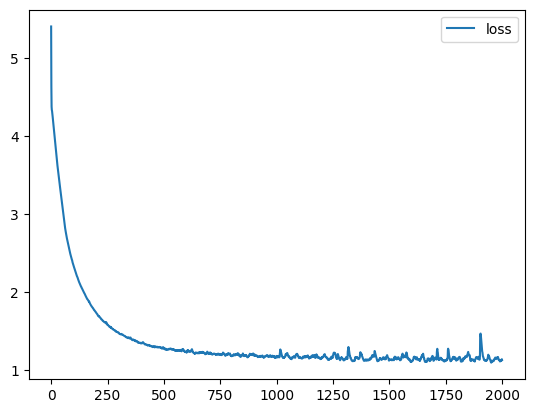

In [106]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

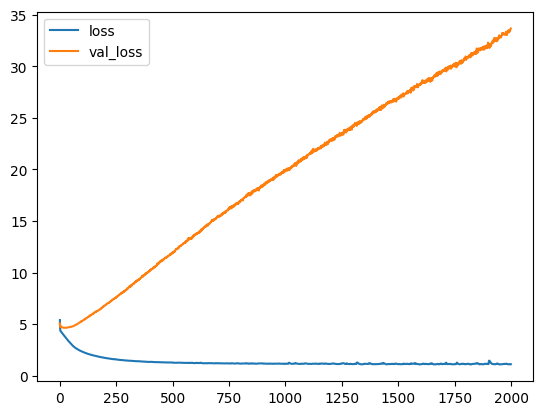

In [107]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

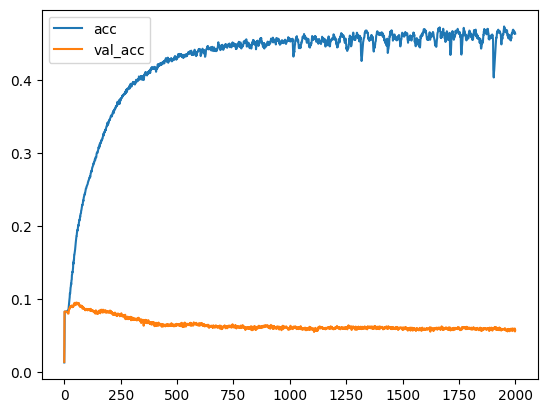

In [108]:
# plot accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show

In [118]:
# make a sampling model
input2 = Input(shape=(1,)) # we’ll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need state to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], output2)

In [119]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [120]:
def sample_line():
    # initial inputs
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))
     # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []
    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])
        print("o.shape, o[0,0,:10]")
        # idx = np.argmax(o[0,0])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(prons), p=probs)
        if idx == eos:
            break;
        # accuulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
        # make the next input into model
        np_input[0,0] = idx
    return ' '.join(output_sentence)


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2860209367.py, line 12)

In [117]:
   # generate a 4 line poem
while True:
    for _ in range(4):
        print(sample_line())
    ans = input("—generate another? [Y/n]—")
    if ans and ans[0].lower().startswith('n'):
        break


NotImplementedError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 517, in call
        raise NotImplementedError('Unimplemented `tf.keras.Model.call()`: if you '

    NotImplementedError: Exception encountered when calling layer "model_5" (type Model).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer "model_5" (type Model):
      • inputs=tf.Tensor(shape=(None, 1), dtype=int64)
      • training=False
      • mask=None
